## Libraries

Let's load libraries that we will need.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.lines import Line2D
from matplotlib import font_manager

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

## Load custom fonts

We will also load in custom fonts we want to use for our plot. The Star Wars themed font "Mandalore" is available for free [here](https://www.1001freefonts.com/mandalore.font).

### Option 1: Download and install locally

(On Windows) Once you downloaded and installed a custom font, you can load the font and use it later in your plot.

You would call the fonts using ``fontproperties=title_font``.

In [ ]:
# load custom fonts
label_font = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\Ubuntu-R.ttf')
title_font = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\Mandalore-K77lD.otf')

### Option 2: Load remote font

You can also load a remote font (e.g. a font file saved on Github) - which is what we will do.

Code comes from Chris Holdgraf (see his full guide [here](https://chrisholdgraf.com/blog/2022/matplotlib-remote-font/)).


In [3]:
import tempfile
from pathlib import Path
import urllib

# Create a temporary directory for the font files
path = Path(tempfile.mkdtemp())

# URL and downloaded path of the fonts
url_label_font = "https://github.com/Lisa-Ho/small-data-projects/raw/main/assets/fonts/Ubuntu-R.ttf"
url_title_font = "https://github.com/Lisa-Ho/small-data-projects/raw/main/assets/fonts/Mandalore-K77lD.otf"
path_label_font = path / "Ubuntu-R.ttf"
path_title_font = path / "Mandalore-K77lD.otf"

# Download the fonts to our temporary directory
urllib.request.urlretrieve(url_label_font, path_label_font)
urllib.request.urlretrieve(url_title_font, path_title_font)

# Create a Matplotlib Font object from our `.ttf` files
label_font = font_manager.FontEntry(fname=str(path_label_font), name="Ubuntu-R")
title_font = font_manager.FontEntry(fname=str(path_title_font), name="Mandalore-K77lD")

# Register objects with Matplotlib's ttf list
font_manager.fontManager.ttflist.append(label_font)
font_manager.fontManager.ttflist.append(title_font)

## Dataset

We will use a data from Star Wars dialogues to create a circular bar plot of each line of Anakin in Episode 1 - The Phantom Menace. The data is sourced, cleaned and checked by Jean Wieme. He made all of the data available for Data Viz projects in [this Github repository](https://github.com/jcwieme/data-scripts-star-wars).

The data set for this tutorial is filtered for Anakin as speaker and was cleaned up a little bit (e.g. inconsistent names).

In [4]:
# load cleaned data set
df = pd.read_csv('https://raw.githubusercontent.com/Lisa-Ho/small-data-projects/main/2023/2308-star-wars-scripts/episode1_each_line_of_anakin_clean.csv')

# print first rows to check it's all looking ok
df.head()

,id,to,text,number,episode
0,271.0,WATTO,Mel tassa cho-passa,3,1
1,274.0,PADME,Are you an angel?,4,1
2,276.0,PADME,An angel. I've heard the deep space pilots tal...,46,1
3,278.0,PADME,I listen to all the traders and star pilots wh...,27,1
4,280.0,PADME,All mylife.,2,1


## Basic circular bar plot
Polar charts plot data in a circular layout. Instead of horizontal and vertical axes, it has an angular (x-axis) and radial (y-axis) axis.

In this example, we want to visualise each line of Anakin as a bar in a circular plot and use the number of words per line as the length of each bar.

We already have the number of words in our data set. Before plotting, we now need to calculate the correct angular position for each bar.


In [5]:
# calculate corect angular position in circular bar plot
x_max = 2*np.pi
df['angular_pos'] = np.linspace(0, x_max, len(df), endpoint=False)

We will visualise each line of Anakin as one bar and color them based on the character he talks to.

So we define a color palette to map to our data and also set a main background color.

The colors are inspired by [this Pudding article](https://pudding.cool/2018/09/wiki-billboard/).


In [6]:
# store colors to use in dictionary
chart_colors = {'bg': '#0C081F', 'QUI-GON': '#F271A7', 'PADME': '#40B8E1', 'OBI-WAN':'#75EAB6',
                'R2D2': '#F4E55E', 'other': '#444A68'}

# map colors for bars to the data
df['colors'] = df['to'].map(chart_colors)

# fill with neutral color for secondary characters
df['colors'] = df['colors'].fillna(chart_colors['other'])

We can check the color palette using seaborn.

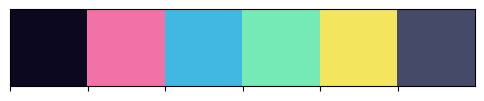

In [7]:
sns.palplot(list(chart_colors.values()))

Now, let's create a simple circular plot.

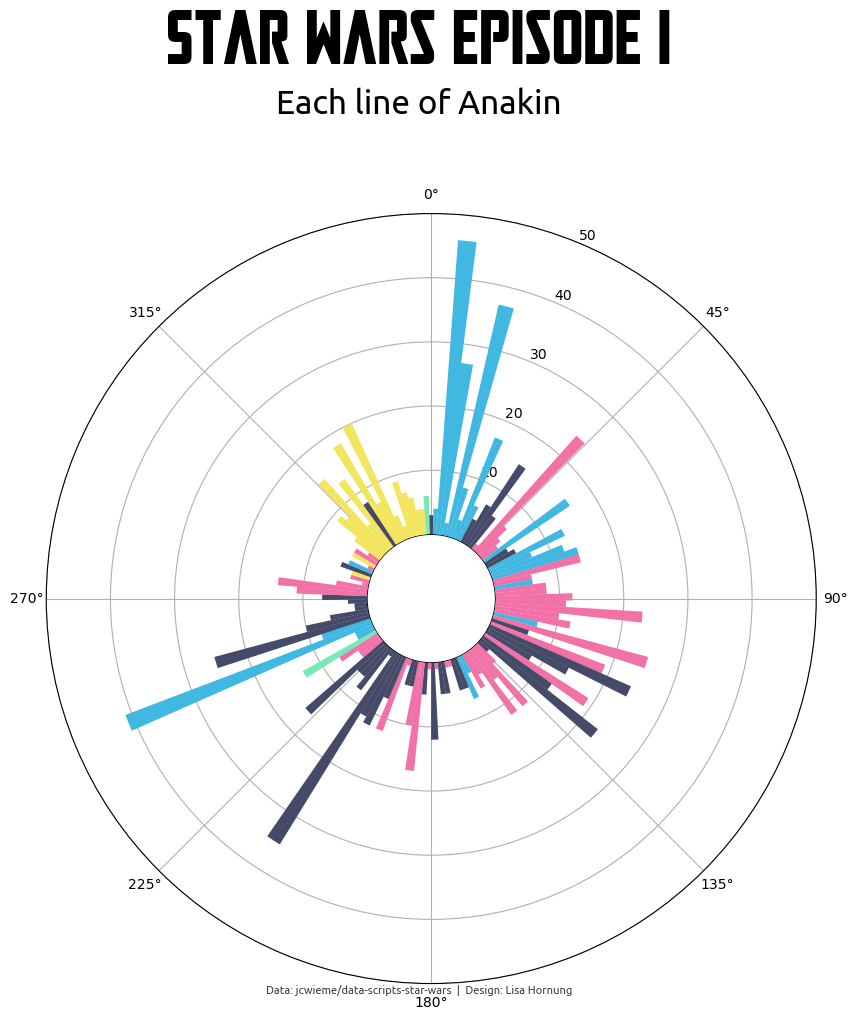

In [8]:
# setup figure with polar projection -----------------------------------------
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})

# plot data -----------------------------------------
ax.bar(df['angular_pos'], df['number'], alpha=1, color=df['colors'] , linewidth=0, width=0.052, zorder=3)

# format axis -----------------------------------------
# set max value and offset from center
max_value = 50
r_offset = -10      
ax.set_rlim(0, max_value)
ax.set_rorigin(r_offset)

# start on the top and plot bars clockwise
ax.set_theta_zero_location('N')     
ax.set_theta_direction(-1)      

# Title + credits -----------------------------------------
plt.figtext(0.5,1.03, 'Star Wars Episode I', fontfamily=title_font.name, fontsize=55, ha='center')
plt.figtext(0.5,0.98, 'Each line of Anakin', fontfamily=label_font.name,fontsize=24, ha='center')
plt.figtext(0.5,0.1, 'Data: jcwieme/data-scripts-star-wars  |  Design: Lisa Hornung',       
            fontfamily=label_font.name,fontsize=8, ha='center', alpha=0.75)

plt.show()

Not too bad, but could do with some cleaning up and enhancements.

## Custom scaling of y-axis

Since we plot bars in a circular plot, the longer the bar it also increases the width of the bar on the outer edges.

We can account for the area size of the bars by adjusting the y-axis as follows. Code sourced from [this tutorial](https://www.chiark.greenend.org.uk/~peterb/python/polar/) by Peter Benie which has a lot more explanations.

We will also format the axis labels and gridlines.

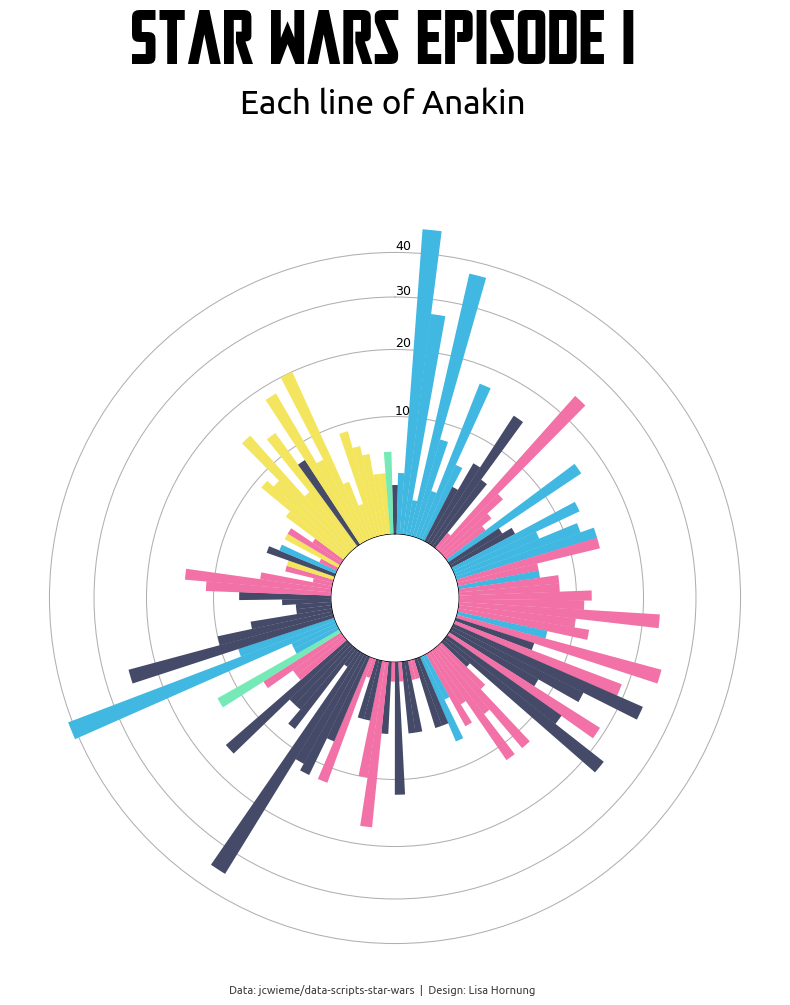

In [9]:
# scale y-axis to account for area size of bars 
max_value = 50
r_offset = -10
r2 = max_value - r_offset
alpha = r2 - r_offset
v_offset = r_offset**2 / alpha
forward = lambda value: ((value + v_offset) * alpha)**0.5 + r_offset
reverse = lambda radius: (radius - r_offset) ** 2 / alpha - v_offset
ax.set_rlim(0, max_value)
ax.set_rorigin(r_offset)
ax.set_yscale('function', functions=(
    lambda value: np.where(value >= 0, forward(value), value),
    lambda radius: np.where(radius > 0, reverse(radius), radius)))

# format labels 
ax.set_rlabel_position(0)
ax.set_yticks([10,20,30,40])
ax.set_yticklabels([10,20,30,40],fontsize=9)

# format gridlines
ax.set_thetagrids(angles=[])
ax.grid(visible=True, axis='y', zorder=2, linewidth=0.75)

# Remove spines
ax.spines[:].set_visible(False)

fig

## Final chart

Putting all the code together and adding a few more bits.

- Change background color to dark and axis labels + gridlines to white.
- Add text annotations + circle in the center
- Add custom legend



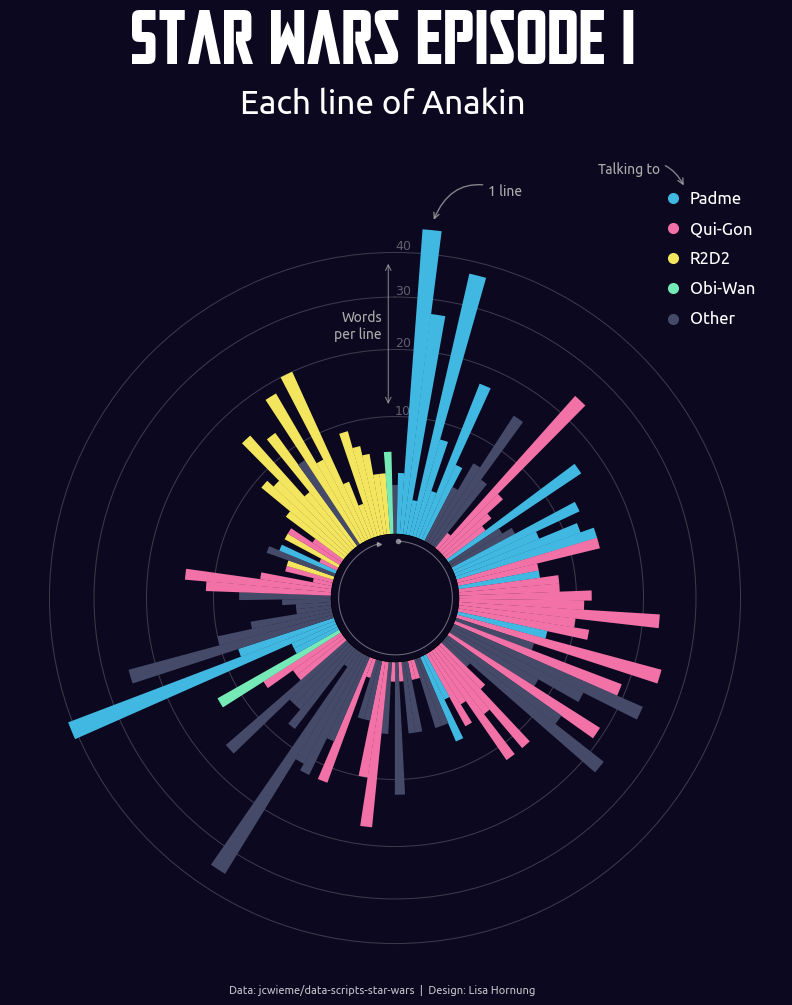

In [10]:
# layout  -----------------------------------------
# setup figure with polar projection
fig, ax = plt.subplots(figsize=(10, 10), 
                       subplot_kw={'projection': 'polar'})

# set background colors
ax.set_facecolor(chart_colors['bg'])
fig.set_facecolor(chart_colors['bg'])

# plot data  -----------------------------------------
ax.bar(df['angular_pos'], df['number'], alpha=1, color=df['colors'], 
       linewidth=0, width=0.052, zorder=3)

# format axis -----------------------------------------
# start on the top and plot bars clockwise
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)   

# scale y-axis to account for area size of bars 
max_value = 50
r_offset = -10
r2 = max_value - r_offset
alpha = r2 - r_offset
v_offset = r_offset**2 / alpha
forward = lambda value: ((value + v_offset) * alpha)**0.5 + r_offset
reverse = lambda radius: (radius - r_offset) ** 2 / alpha - v_offset
ax.set_rlim(0, max_value)
ax.set_rorigin(r_offset)
ax.set_yscale('function', functions=(
    lambda value: np.where(value >= 0, forward(value), value),
    lambda radius: np.where(radius > 0, reverse(radius), radius)))

# format labels and grid
ax.set_rlabel_position(0)
ax.set_yticks([10,20,30,40])
ax.set_yticklabels([10,20,30,40],fontsize=9, color='white',alpha=0.35)

# format gridlines
ax.set_thetagrids(angles=[])
ax.grid(visible=True, axis='y', zorder=2, color='white',
        linewidth=0.75, alpha=0.2)

# remove spines
ax.spines[:].set_visible(False)

# custom legend  -----------------------------------------
# add axis to hold legend
lgd = fig.add_axes([0.75,0.71, 0.15, 0.25]) 

# define legend elements
kw = dict(marker='o', color=chart_colors['bg'], markersize=8, alpha=1, 
          markeredgecolor='None', linewidth=0)
legend_elements =[Line2D([0],[0], 
                          markerfacecolor=chart_colors['PADME'],
                          label='Padme', 
                          **kw), 
                  Line2D([0], [0], 
                         markerfacecolor=chart_colors['QUI-GON'],
                         label='Qui-Gon', 
                         **kw), 
                  Line2D([0], [0], 
                         markerfacecolor=chart_colors['R2D2'], 
                         label='R2D2', 
                         **kw), 
                  Line2D([0], [0], 
                         markerfacecolor=chart_colors['OBI-WAN'], 
                         label='Obi-Wan', 
                         **kw), 
                  Line2D([0], [0], 
                         markerfacecolor=chart_colors['other'], 
                         label='Other', 
                         **kw)] 

# visualise legend and remove axis around it
L = lgd.legend(frameon=False, handles=legend_elements, loc='center', 
               ncol=1, handletextpad=0.2, labelspacing=1)
plt.setp(L.texts, va='baseline', color='white', size=12, 
         fontfamily=label_font.name)    
lgd.axis('off')

# circular annotation  -----------------------------------------
# draw an inner circle on a new axis
circ = fig.add_axes([0.453, 0.435, 0.12, 0.12],polar=True) 
line_angular_pos = df['angular_pos'][1:-5]
line_r = [5] * len(line_angular_pos)

#plot line and markers for start + end
circ.plot(line_angular_pos, line_r, zorder=5, color='white', 
          linewidth=0.75, alpha=0.4)
circ.plot(line_angular_pos.to_list()[0], line_r[0], zorder=5, color='white', 
          linewidth=0,marker='o', markersize=3,alpha=0.4)
circ.plot(line_angular_pos.to_list()[-1], line_r[-1], zorder=5, color='white', 
          linewidth=0,marker='>', markersize=3,alpha=0.4)

# format axis
circ.set_theta_zero_location('N')
circ.set_theta_direction(-1)  
circ.axis('off')

# text annotations -----------------------------------------
ax.annotate('1 line', xy=(0.1, 48), xycoords='data', xytext=(40, 20), 
            textcoords='offset points', 
            fontsize=10, fontfamily=label_font.name,
            ha='left', va='baseline', 
            annotation_clip=False, 
            color='#ababab',
            arrowprops=dict(arrowstyle='->',edgecolor='#ababab', 
                            connectionstyle='arc3,rad=.5', alpha=0.75))
ax.annotate('Words\nper line', xy=(-0.05, 22), xycoords='data', xytext=(0, 0), 
            textcoords='offset points', 
            fontsize=10, fontfamily=label_font.name,
            ha='right', va='baseline', 
            annotation_clip=False, 
            color='#ababab')
ax.annotate('', xy=(-0.02, 38), xycoords='data', xytext=(0, -105), 
            textcoords='offset points', 
            fontsize=10, fontfamily=label_font.name,
            ha='right', va='baseline', 
            annotation_clip=False, 
            color='#ababab',
            arrowprops=dict(arrowstyle='<->',edgecolor='#ababab', linewidth=0.75,
                            connectionstyle='arc3,rad=0', alpha=0.75 ))
lgd.annotate('Talking to', xy=(0.35, 0.78), xycoords='data', xytext=(-18, 14), 
             textcoords='offset points', 
            fontsize=10, fontfamily=label_font.name,
            ha='right', va='center', 
            annotation_clip=False, 
            color='#ababab',
            arrowprops=dict(arrowstyle='->',edgecolor='#ababab', 
                            connectionstyle='arc3,rad=-.5', alpha=0.75))

# Title + Credits  -----------------------------------------
plt.figtext(0.5,1.03, 'Star Wars Episode I', 
            fontfamily=title_font.name, 
            fontsize=55, color='white', ha='center')
plt.figtext(0.5,0.98, 'Each line of Anakin', 
            fontfamily=label_font.name,
            fontsize=24, color='white', ha='center')
plt.figtext(0.5,0.1, 'Data: jcwieme/data-scripts-star-wars  |  Design: Lisa Hornung', 
            fontfamily=label_font.name,
            fontsize=8, color='white', ha='center', alpha=0.75)


plt.show()

## Going further

For more examples of **how to create or customize** your plots with matplotlib, see the [circular bar plot section](https://python-graph-gallery.com/circular-barplot/). 